## Loading and Setup

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
# Load the dataset
df = pd.read_parquet('dataset/accepted_2007_to_2018Q4.parquet')

## Assessment

In [19]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [21]:
# Print the shape of the dataset
df.shape

(22511, 151)

In [22]:
# Print the first 5 rows of the dataset
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,None,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,None,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,None,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,None,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,None,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,None,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,N

In [23]:
# Display the info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22511 entries, 0 to 22510
Columns: 151 entries, id to settlement_term
dtypes: float64(114), int64(1), object(36)
memory usage: 25.9+ MB


In [24]:
# Display the data types of the dataset
df.dtypes

id                                              int64
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

In [18]:
# Check the number of unique values in each column
df.nunique()

id                                            22511
member_id                                         0
loan_amnt                                      1140
funded_amnt                                    1140
funded_amnt_inv                                1190
term                                              2
int_rate                                         64
installment                                    6915
grade                                             7
sub_grade                                        35
emp_title                                     10992
emp_length                                       11
home_ownership                                    3
annual_inc                                     2442
verification_status                               3
issue_d                                           1
loan_status                                       6
pymnt_plan                                        2
url                                           22511
desc        

In [25]:
# Get a statistical summary of the dataset
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,2.251100e+04,0.0,22511.000000,22511.000000,22511.000000,22511.000000,22511.000000,2.251100e+04,22509.000000,22510.000000,22510.000000,22510.000000,22510.000000,11637.000000,4038.00000,22510.000000,22510.000000,22510.000000,22499.00000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,6466.000000,22510.0,169.000000,169.000000,22510.000000,22510.000000,2.251000e+04,21344.000000,21344.000000,21344.000000,21344.000000,20785.000000,21344.000000,18595.000000,21344.000000,21344.000000,21344.000000,21344.000000,22510.000000,21344.000000,21344.000000,21344.000000,22510.000000,22510.000000,22296.000000,22282.000000,22510.000000,22510.000000,21919.000000,22510.000000,22510.000000,22510.000000,22510.000000,22303.000000,5715.000000,20159.000000,8085.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,22510.000000,21560.000000,22510.000000,22510.000000,22510.000000,22510.000000,22282.000000,22510.000000,22510.000000,2.251000e+04,22510.000000,22510.000000,22510.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,180.000000,180.0,180.000000,144.000000,180.000000,180.000000,662.000000,662.000000,662.000000
mean,6.756447e+07,NaN,15031.787793,15031.787793,15025.527520,12.255020,436.321286,7.820695e+04,19.423974,0.335584,695.075522,699.075611,0.608796,34.162929,65.69787,12.140116,0.238250,17388.656908,51.57675,25.538783,994.961977,994.471550,15043.269607,15037.171987,12062.974932,2748.012439,2.121175,230.161043,41.006250,4262.523270,677.663172,661.832519,0.023678,44.457934,1.0,114705.080296,18.990828,0.004798,279.812306,1.435598e+05,1.108602,2.928879,0.761525,1.674100,20.917873,36538.676068,71.576499,1.388587,2.974747,5887.961207,60.874859,34865.387161,0.943919,1.537341,2.233602,4.876499,13311.317859,10591.638366,59.810511,0.008574,14.074500,127.087823,185.524878,13.055664,7.452466,1.653354,23.932700,39.150306,6.458108,35.480891,0.529542,3.725011,5.692625,4.8396

Here are some of the key statistics:

- The average loan amount (loan_amnt) is approximately $15,031.8.
- The minimum loan amount is $1,000, and the maximum is $35,000.
- The average interest rate (int_rate) is approximately 12.255%.
- The average annual income (annual_inc) of borrowers is approximately $78,206.9.

In [26]:
# Check the number of null values in each column
df.isnull().sum()

id                                                0
member_id                                     22511
loan_amnt                                         0
funded_amnt                                       0
funded_amnt_inv                                   0
term                                              0
int_rate                                          0
installment                                       0
grade                                             0
sub_grade                                         0
emp_title                                      1349
emp_length                                     1340
home_ownership                                    0
annual_inc                                        0
verification_status                               0
issue_d                                           0
loan_status                                       0
pymnt_plan                                        0
url                                               0
desc        

In [12]:
# Check for duplicate rows
df.duplicated().sum()

0

## Cleaning

In [30]:
# Create a copy of the original dataframe
df_clean = df.copy()

# Drop 'id' and 'member_id' column
df_clean.drop(['id', 'member_id'], axis=1, inplace=True)

# Display the first few rows of the cleaned dataframe
df_clean.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,None,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,None,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,None,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,None,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,None,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,None,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [33]:
# Check the percentage of missing values in each column
df_clean.isnull().sum() / len(df_clean) * 100

loan_amnt                                       0.000000
funded_amnt                                     0.000000
funded_amnt_inv                                 0.000000
term                                            0.000000
int_rate                                        0.000000
installment                                     0.000000
grade                                           0.000000
sub_grade                                       0.000000
emp_title                                       5.992626
emp_length                                      5.952645
home_ownership                                  0.000000
annual_inc                                      0.000000
verification_status                             0.000000
issue_d                                         0.000000
loan_status                                     0.000000
pymnt_plan                                      0.000000
url                                             0.000000
desc                           

In [34]:
# Get the columns with more than 20% missing values
cols_to_drop = df_clean.columns[df_clean.isnull().sum() / len(df_clean) * 100 > 20]

# Drop the columns with more than 20% missing values
df_clean.drop(cols_to_drop, axis=1, inplace=True)

In [35]:
# Check the shape of the dataframe
df_clean.shape

(22511, 106)

In [36]:
# Check the percentage of missing values in each column
df_clean.isnull().sum() / len(df_clean) * 100


loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      5.992626
emp_length                     5.952645
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
purpose                        0.000000
title                          0.590822
zip_code                       0.004442
addr_state                     0.004442
dti                            0.008885
delinq_2yrs                    0.004442
earliest_cr_line               0.004442
fico_range_low                 0.004442


In [37]:
# Get the columns with less than 20% missing values
cols_to_fill = df_clean.columns[df_clean.isnull().sum() / len(df_clean) * 100 < 20]

# Fill the missing values with the mean of the respective columns for float columns
for col in cols_to_fill:
    if df_clean[col].dtype == 'float64':
        df_clean[col].fillna(df_clean[col].mean(), inplace=True)

# Fill the missing values with the mode of the respective columns for object columns
for col in cols_to_fill:
    if df_clean[col].dtype == 'object':
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Check the percentage of missing values in each column 
df_clean.isnull().sum() / len(df_clean) * 100

loan_amnt                     0.0
funded_amnt                   0.0
funded_amnt_inv               0.0
term                          0.0
int_rate                      0.0
installment                   0.0
grade                         0.0
sub_grade                     0.0
emp_title                     0.0
emp_length                    0.0
home_ownership                0.0
annual_inc                    0.0
verification_status           0.0
issue_d                       0.0
loan_status                   0.0
pymnt_plan                    0.0
url                           0.0
purpose                       0.0
title                         0.0
zip_code                      0.0
addr_state                    0.0
dti                           0.0
delinq_2yrs                   0.0
earliest_cr_line              0.0
fico_range_low                0.0
fico_range_high               0.0
inq_last_6mths                0.0
open_acc                      0.0
pub_rec                       0.0
revol_bal     

## EDA

In [39]:
print(df_clean['loan_status'].unique())

['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)']


In [42]:
# Get the count of each unique value in 'loan_status' column
df_clean['loan_status'].value_counts()

Fully Paid            15888
Charged Off            4038
Current                2401
Late (31-120 days)      119
In Grace Period          53
Late (16-30 days)        12
Name: loan_status, dtype: int64

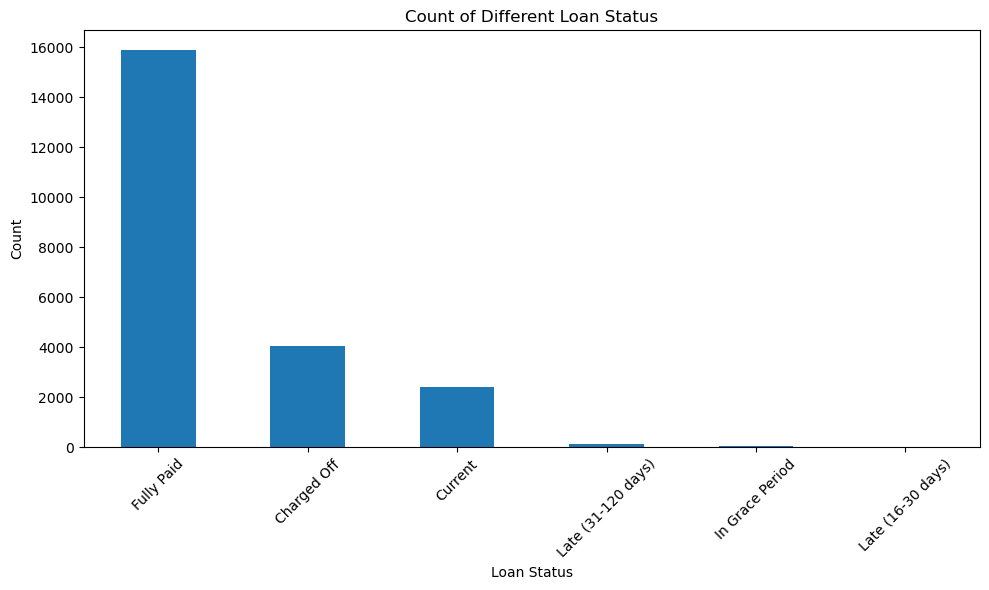

In [50]:
# Create a bar plot for the count of each unique value in 'loan_status' column
plt.figure(figsize=(10, 6))
df_clean['loan_status'].value_counts().plot(kind='bar')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Count of Different Loan Status')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [51]:
# Get the percentage of each unique value in 'loan_status' column
df_clean['loan_status'].value_counts() / len(df_clean) * 100

Fully Paid            70.578828
Charged Off           17.937897
Current               10.665897
Late (31-120 days)     0.528630
In Grace Period        0.235440
Late (16-30 days)      0.053307
Name: loan_status, dtype: float64

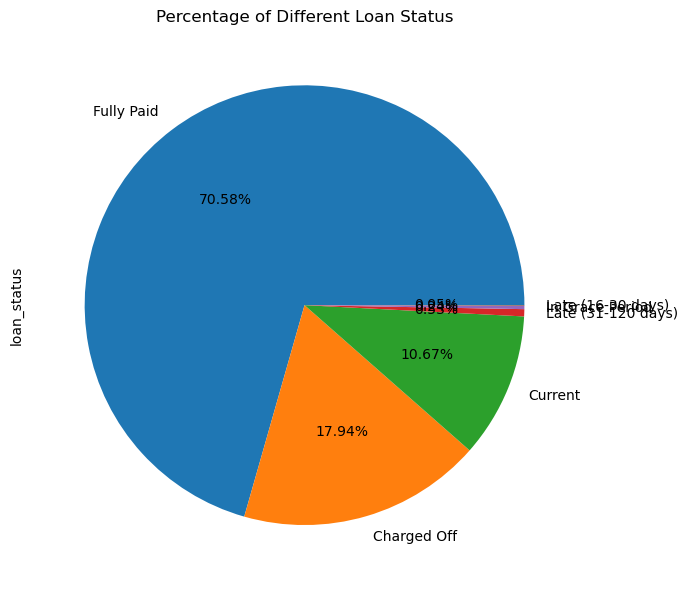

In [62]:
# Create a pie chart for the percentage of each unique value in 'loan_status' column
plt.figure(figsize=(10, 6))
loan_status_counts = df_clean['loan_status'].value_counts()
loan_status_counts.plot(kind='pie', autopct='%1.2f%%')
plt.title('Percentage of Different Loan Status')
plt.tight_layout()
plt.show()

In [68]:
# Create a new DataFrame with modified loan_status values
df_modified = df_clean.copy()
df_modified['loan_status'] = df_modified['loan_status'].replace(['Fully Paid', 'Current'], 'Good')
df_modified['loan_status'] = df_modified['loan_status'].replace(['Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period'], 'Late')
df_modified['loan_status'] = df_modified['loan_status'].replace(['Charged Off'], 'Bad')

# Show the first 5 rows of the modified DataFrame
df_modified.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Good,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.000000,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Good,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.000000,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Good,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Debt consolidation,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.000000,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Good,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,67300.0,0

In [67]:
# Get the count of each unique value in 'loan_status' column
df_modified['loan_status'].value_counts()

Good    18289
Bad      4038
Late      184
Name: loan_status, dtype: int64

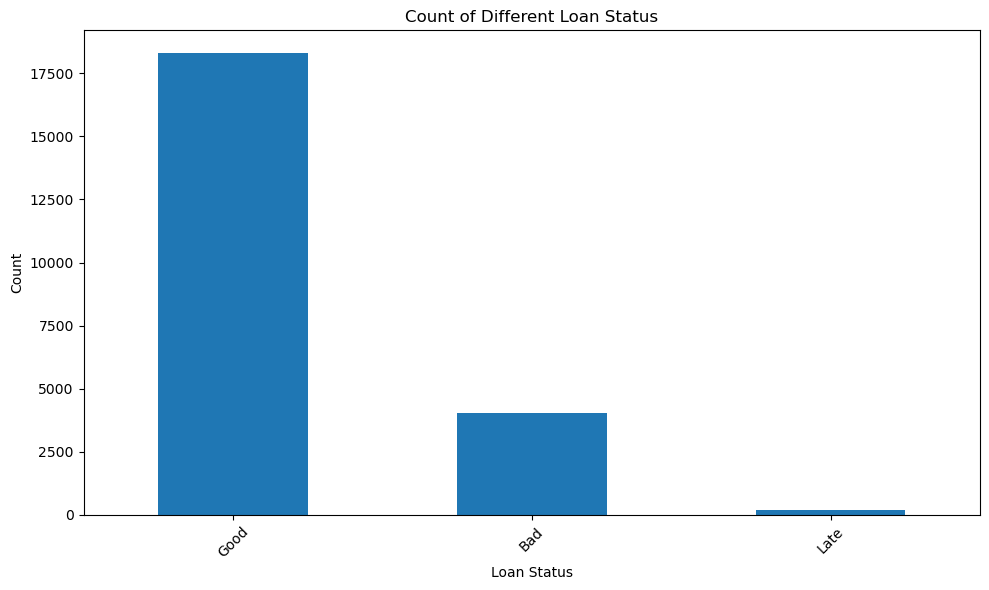

In [65]:
# Create a bar plot for count of values in the modified 'loan_status' column
plt.figure(figsize=(10, 6))
df_modified['loan_status'].value_counts().plot(kind='bar')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Count of Different Loan Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [69]:
# Get the percentage of each unique value in 'loan_status' column
df_modified['loan_status'].value_counts() / len(df_modified) * 100

Good    81.244725
Bad     17.937897
Late     0.817378
Name: loan_status, dtype: float64

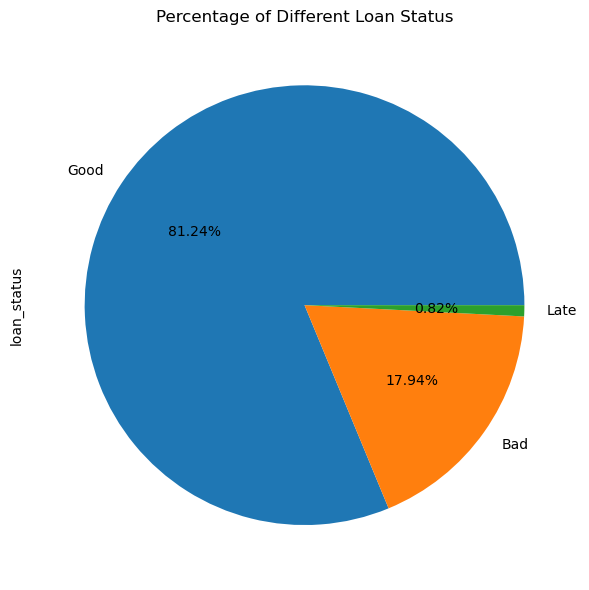

In [64]:
# Create a pie chart for the percentage of each unique value in the modified 'loan_status' column
plt.figure(figsize=(10, 6))
loan_status_counts = df_modified['loan_status'].value_counts()
loan_status_counts.plot(kind='pie', autopct='%1.2f%%')
plt.title('Percentage of Different Loan Status')
plt.tight_layout()
plt.show()

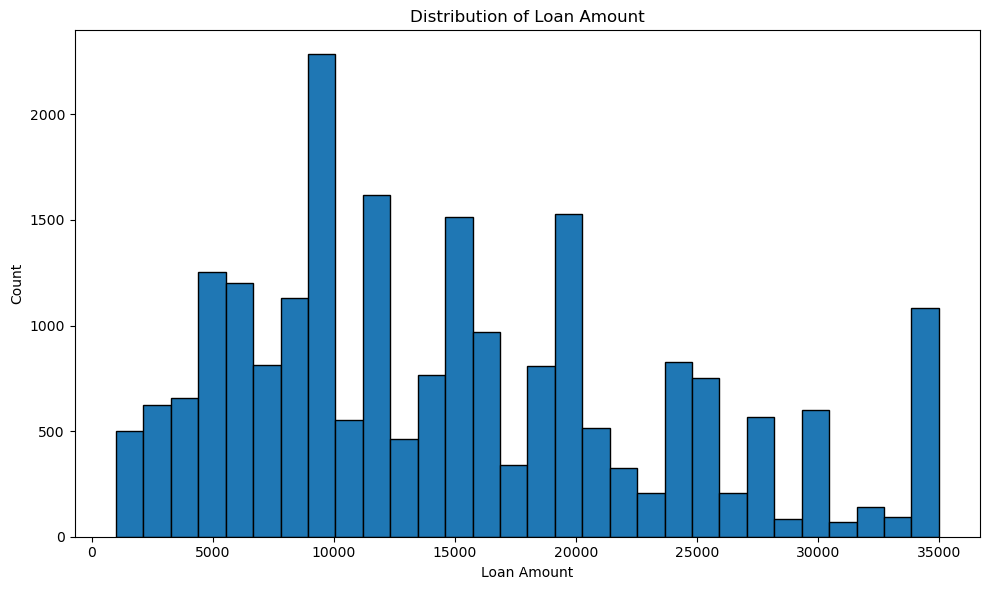

In [71]:
# Plot a histogram for the 'loan_amnt' column
plt.figure(figsize=(10, 6))
plt.hist(df_modified['loan_amnt'], bins=30, edgecolor='black')
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.title('Distribution of Loan Amount')
plt.tight_layout()
plt.show()

The histogram shows the distribution of loan amounts in the dataset: 
- Most of the loans are in the range of $5,000 to $20,000.

In [77]:
# Display the data types of the dataset
df_modified.dtypes

loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                    object
pymnt_plan                     object
url                            object
purpose                        object
title                          object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
fico_range_low                float64
fico_range_high               float64
inq_last_6mt

In [78]:
# Create a list of numerical columns
num_cols = df_clean.select_dtypes(include=np.number).columns.tolist()

# Create a list of high correlation features
high_corr_features = []

# Create two for loops to check the correlation between numerical columns
for col1 in num_cols:
    for col2 in num_cols:
        if col1 != col2:
            correlation = df_clean[col1].corr(df_clean[col2])
            if correlation > 0.7: 
                high_corr_features.append((col1, col2, correlation))

# Print the list of high correlation features
for feature in high_corr_features:
    print(f"High correlation: {feature[0]} - {feature[1]} (Correlation: {feature[2]:.2f})")


High correlation: loan_amnt - funded_amnt (Correlation: 1.00)
High correlation: loan_amnt - funded_amnt_inv (Correlation: 1.00)
High correlation: loan_amnt - installment (Correlation: 0.94)
High correlation: loan_amnt - total_pymnt (Correlation: 0.87)
High correlation: loan_amnt - total_pymnt_inv (Correlation: 0.87)
High correlation: loan_amnt - total_rec_prncp (Correlation: 0.77)
High correlation: funded_amnt - loan_amnt (Correlation: 1.00)
High correlation: funded_amnt - funded_amnt_inv (Correlation: 1.00)
High correlation: funded_amnt - installment (Correlation: 0.94)
High correlation: funded_amnt - total_pymnt (Correlation: 0.87)
High correlation: funded_amnt - total_pymnt_inv (Correlation: 0.87)
High correlation: funded_amnt - total_rec_prncp (Correlation: 0.77)
High correlation: funded_amnt_inv - loan_amnt (Correlation: 1.00)
High correlation: funded_amnt_inv - funded_amnt (Correlation: 1.00)
High correlation: funded_amnt_inv - installment (Correlation: 0.94)
High correlation: fu

In [80]:
# Create a correlation matrix
corr_matrix = df_clean[num_cols].corr()
corr_matrix

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
loan_amnt,1.000000,1.000000,0.999994,0.159481,0.944435,0.338291,0.025647,-0.032095,0.117242,0.117238,-0.023369,0.187865,-0.076532,0.331013,0.123479,0.201342,0.302985,0.302982,0.873504,0.873476,0.774270,0.684188,0.088794,0.166923,0.166042,0.405019,0.071446,0.065463,-0.038356,NaN,-0.003380,-0.013697,0.302250,-0.039167,0.027543,-0.012752,0.023744,-0.010897,0.132533,-0.097316,-0.049853,-0.027147,0.402174,0.018551,0.348626,0.009841,0.069636,0.007993,0.003942,0.212752,0.185160,0.062892,-0.007526,-0.006509,0.123262,0.168486,0.048550,0.029084,0.222213,0.032490,-0.004599,-0.056177,0.209176,0.171567,0.228676,0.203169,0.071839,0.171441,0.172881,0.167620,0.188225,0.006246,-0.006544,-0.034727,-0.035200,0.099607,0.024658,-0.104572,-0.004784,0.330809,0.270128,0.369667,0.197248
funded_amnt,1.000000,1.000000,0.999994,0.159481,0.944435,0.338291,0.025647,-0.032095,0.117242,0.117238,-0.023369,0.187865,-0.076532,0.331013,0.123479,0.201342,0.302985,0.302982,0.873504,0.873476,0.774270,0.684188,0.088794,0.166923,0.166042,0.405019,0.071446,0.065463,-0.038356,NaN,-0.003380,-0.013697,0.302250,-0.039167,0.027543,-0.012752,0.023744,-0.010897,0.132533,-0.097316,-0.049853,-0.027147,0.402174,0.018551,0.348626,0.009841,0.069636,0.007993,0.003942,0.212752,0.185160,0.062892,-0.007526,-0.006509,0.123262,0.168486,0.048550,0.029084,0.222213,0.032490,-0.004599,-0.056177,0.209176,0.171567,0.228676,0.203169,0.071839,0.171441,0.172881,0.167620,0.188225,0.006246,-0.006544,-0.034727,-0.035200,0.099607,0.024658,-0.104572,-0.004784,0.330809,0.270128,0.369667,0.197248
funded_amnt_inv,0.999994,0.999994,1.000000,0.158885,0.944405,0.338404,0.025463,-0.032159,0.117535,0.117530,-0.023452,0.187841,-0.076572,0.331030,0.123289,0.201377,0.302952,0.302952,0.873536,0.873519,0.774403,0.683949,0.088765,0.166784,0.165900,0.405028,0.071686,0.065672,-0.038370,NaN,-0.003403,-0.013695,0.302280,-0.039278,0.027508,-0.012894,0.023599,-0.010817,0.132498,-0.097396,-0.049978,-0.027258,0.402276,0.018352,0.348768,0.009754,0.069651,0.007873,0.003774,0.212781,0.185368,0.062705,-0.007538,-0.006503,0.123312,0.168629,0.048626,0.029197,0.222264,0.032554,-0.004524,-0.056260,0.209144,0.171473,0.228726,0.203252,0.071807,0.171432,0.172950,0.167515,0.188201,0.006264,-0.006583,-0.034766,-0.035375,0.099662,0.024462,-0.104527,-0.004885,0.330865,0.270109,0.369860,0.197235
int_rate,0.159481,0.159481,0.158885,1.000000,0.139110,-0.107778,0.185894,0.035607,-0.388181,-0.388180,0.248824,-0.018609,0.070460,-0.055810,0.206189,-0.044093,0.164632,0.164525,0.080485,0.079967,-0.077711,0.454630,0.078432,0.185171,0.185757,0.082206,-0.371595,-0.297194,0.026885,NaN,0.015584,0.016465,-0.092540,0.219012,0.043148,0.237431,0.193378,-0.123116,0.051295,0.167540,0.171915,0.166542,-0.101538,0.279178,-0.205207,0.165758,0.019872,0.249512,0.229785,-0.084866,

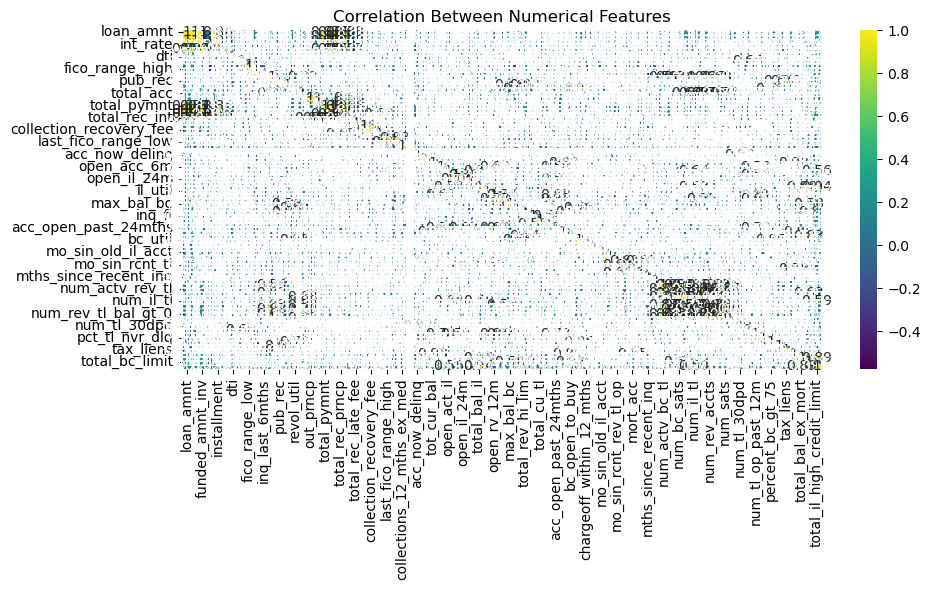

In [81]:
# Create a heatmap to visualize the correlation between the numerical columns
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Between Numerical Features')
plt.tight_layout()
plt.show()

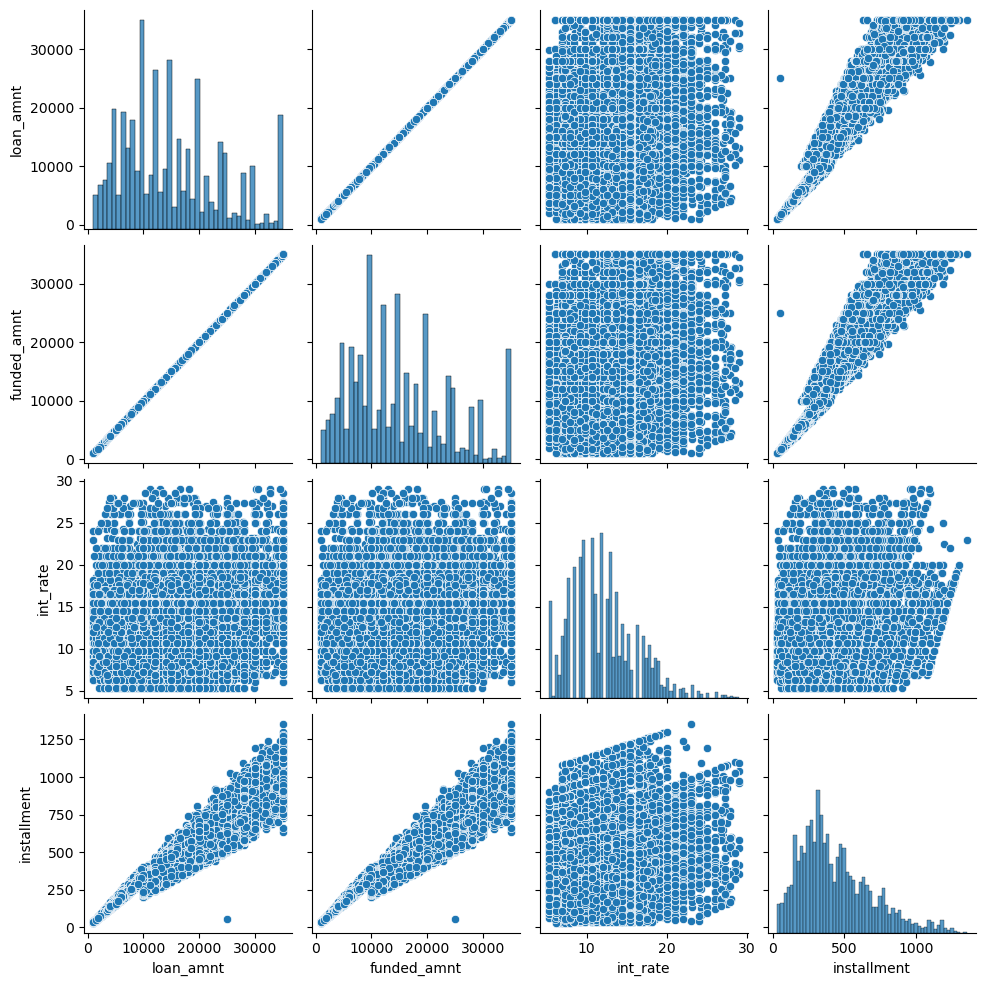

In [29]:
# Select a subset of columns for the pairplot
cols = ['loan_amnt', 'funded_amnt', 'int_rate', 'installment']

# Create a pairplot
sns.pairplot(df_clean[cols])

The reason for selecting these specific columns (loan_amnt, funded_amnt, int_rate, and installment) is because they are key numerical variables that are likely to have a significant impact on the loan status:

- loan_amnt: This is the amount of the loan applied for by the borrower. If the loan amount is high, it might be harder for the borrower to repay the loan, which could affect the loan status.
- funded_amnt: This is the total amount committed to that loan at that point in time. It's similar to loan_amnt and can also affect the loan status.
- int_rate: This is the interest rate on the loan. A higher interest rate means the borrower has to pay more over the life of the loan, which could make it harder for them to repay the loan.
- installment: This is the monthly payment owed by the borrower. If the installment is high, it might be harder for the borrower to keep up with payments, which could affect the loan status.

From the pairplot, we can observe the following:

- loan_amnt and funded_amnt are highly positively correlated, which is expected as the funded amount should be close to the loan amount. This is evident from the scatter plot which shows a nearly straight line, indicating a strong linear relationship.
- int_rate and installment show no clear correlation. The scatter plot does not show any clear trend, indicating that there might not be a strong linear relationship between interest rate and installment.
- The distributions of loan_amnt, funded_amnt, and installment are skewed to the right, indicating that most of the loans have lower amounts and installments. The distribution of int_rate seems to be more evenly spread out, but still shows a slight right skew.

In [30]:
# Initialize a label encoder
le = LabelEncoder()

# Convert 'loan_status' to numerical form
df_clean['loan_status'] = le.fit_transform(df_clean['loan_status'])

# Get the correlation of 'loan_status' with other variables
loan_status_corr = df_clean.corr()['loan_status']

# Sort the correlations
sorted_corr = loan_status_corr.sort_values(ascending=False)

# Display the sorted correlations
sorted_corr

/var/folders/ld/9fn5vq1d5xj0hkczvfgx86_w0000gn/T/ipykernel_6582/2518514161.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loan_status_corr = df_clean.corr()['loan_status']


loan_status                            1.000000
last_fico_range_high                   0.580221
last_fico_range_low                    0.514585
total_rec_prncp                        0.387152
last_pymnt_amnt                        0.316959
                                         ...   
sec_app_chargeoff_within_12_mths            NaN
sec_app_collections_12_mths_ex_med          NaN
sec_app_mths_since_last_major_derog         NaN
deferral_term                               NaN
hardship_length                             NaN
Name: loan_status, Length: 115, dtype: float64

From this list, we can see that variables such as **last_fico_range_high, last_fico_range_low, total_rec_prncp, and last_pymnt_amnt** have relatively high positive correlations with **loan_status**. 

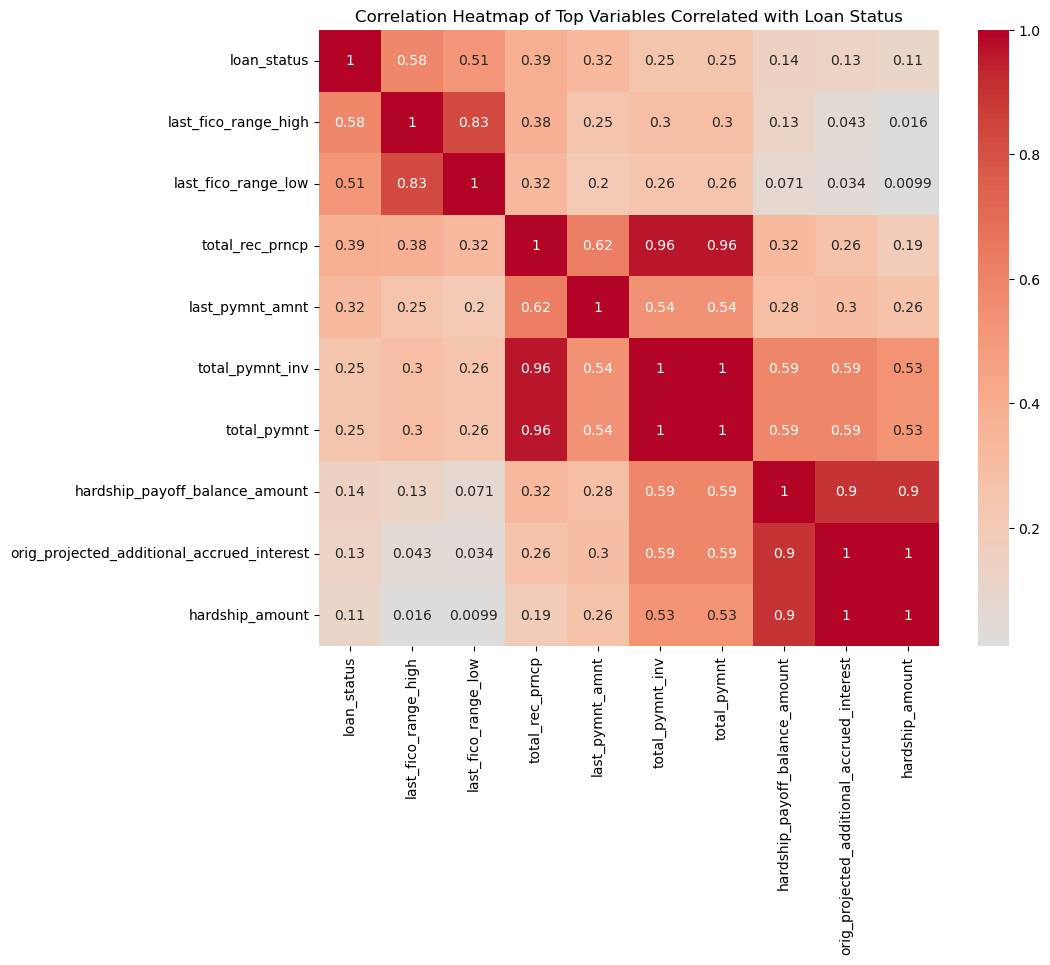

In [31]:
# Select the top 10 variables with the highest correlation with 'loan_status'
top_corr_vars = sorted_corr.index[:10]

# Create a correlation matrix for these variables
top_corr = df_clean[top_corr_vars].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr, cmap='coolwarm', center=0, annot=True)
plt.title('Correlation Heatmap of Top Variables Correlated with Loan Status')
plt.show()


The heatmap shows the correlation coefficients between the top 10 variables most correlated with loan_status. The color of each cell represents the strength and direction of the correlation: a color close to red indicates a strong positive correlation, a color close to blue indicates a strong negative correlation, and a color close to white or light purple indicates little to no correlation.

From this heatmap, we can see that **loan_status** has a strong positive correlation with **last_fico_range_high, last_fico_range_low, total_rec_prncp, and last_pymnt_amnt**. This suggests that these variables could be important features for predicting loan_status.